In [1]:
import requests
import os
import sys
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34478398/import-local-function-
# from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import local_module as local

In [2]:
# not all years have this data to the tract level?
# look at the supported geography section of each year
# https://acsdatacommunity.prb.org/discussion-forum/f/forum/405/api-change-for-2017-5-year-data-for-tracts   

In [3]:
# read api keys file and assign variables
df = pd.read_csv('../data/raw/api_keys.csv')
census_api_key = df.loc[df['API'] == 'census']['KEY'].iloc[0]

# Geographic Data

In [4]:
url = r"https://www2.census.gov/geo/tiger/TIGER2020/TRACT/"
zips = local.get_zip(url)

dfs = [] # initialize empty list to hold tract geodataframes

for file in zips:
    dfs.append(gp.read_file(file)) # read in tract files and add to list

tracts = pd.concat(dfs) # combine tracts into single geodataframe

/opt/anaconda3/envs/gds/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# ACS Data

In [5]:
# https://code.activestate.com/recipes/577775-state-fips-codes-dict/
state_codes_dict = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

state_codes_list = list(state_codes_dict.values())

In [6]:
# test API call
url = "https://api.census.gov/data/2009/acs/acs5?get=B08301_001E,B08301_018E,B08301_019E&for=tract:*&in=state:53&key={0}"\
    .format(census_api_key)

response = requests.request("GET", url)

test = local.json_to_dataframe(response)
test.head()

,B08301_001E,B08301_018E,B08301_019E,state,county,tract
0,2649,47,146,53,007,960200
1,2742,0,225,53,007,960300
2,1463,0,30,53,007,960400
3,3729,0,245,53,007,960500
4,1850,10,111,53,007,960600


In [7]:
means_transpo = pd.DataFrame()

for code in state_codes_list:
    # build url
    url = "https://api.census.gov/data/2020/acs/acs5?get=B08301_001E,B08301_018E,B08301_019E&for=tract:*&in=state:"\
    + code + "&key={0}"\
    .format(census_api_key)
    
    # request
    response = requests.request("GET", url)

    # convert to dataframe
    df = local.json_to_dataframe(response)

    # add to dataframe
    means_transpo = pd.concat([means_transpo, df])

In [8]:
means_transpo.head()

,B08301_001E,B08301_018E,B08301_019E,state,county,tract
0,1532,0,4,53,003,960100
1,2392,0,0,53,003,960200
2,1557,18,117,53,003,960300
3,839,0,0,53,003,960400
4,1534,0,62,53,003,960500


In [9]:
# clean up dataframe

# https://api.census.gov/data/2020/acs/acs5/variables.html
var_dict = {
    "B08301_001E": "TOTAL",
    "B08301_018E": "BICYCLE",
    "B08301_019E": "WALKED"
}

# recast type
for var in list(var_dict.keys()):
    means_transpo[var] = means_transpo[var].astype(int)
    
# rename columns
means_transpo.rename(columns=var_dict, inplace=True)

# calculate relative columns
means_transpo["P_BICYCLE"] = means_transpo["BICYCLE"] / means_transpo["TOTAL"]
means_transpo["P_WALKED"] = means_transpo["WALKED"] / means_transpo["TOTAL"]

# replace NaN with 0 in percentage columns
means_transpo.fillna(
    {
    "P_BICYCLIST": 0, 
    "P_WALKED": 0
    }, inplace=True
)

# reorder columns
cols = ['state','county','tract','TOTAL','BICYCLE','WALKED','P_BICYCLE','P_WALKED']
means_transpo = means_transpo[cols]

means_transpo.head()

,state,county,tract,TOTAL,BICYCLE,WALKED,P_BICYCLE,P_WALKED
0,53,003,960100,1532,0,4,0.000000,0.002611
1,53,003,960200,2392,0,0,0.000000,0.000000
2,53,003,960300,1557,18,117,0.011561,0.075145
3,53,003,960400,839,0,0,0.000000,0.000000
4,53,003,960500,1534,0,62,0.000000,0.040417


# Join

In [10]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,01,017,953800,01017953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,01,017,954300,01017954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,01,017,954700,01017954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."


In [11]:
# merge tabular and geospatial data
tracts = tracts.merge(
    means_transpo, 
    how="left", 
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"], 
    right_on=["state", "county", "tract"],
    validate="1:1"
)

In [12]:
# visualization
# https://code.activestate.com/recipes/577775-state-fips-codes-dict/
state_codes = {
    'WA': '53', 
    'DE': '10', 
    'DC': '11', 
    'WI': '55', 
    'WV': '54', 
    # 'HI': '15',
    'FL': '12', 
    'WY': '56', 
    # 'PR': '72', 
    'NJ': '34',
    'NM': '35', 
    'TX': '48',
    'LA': '22', 
    'NC': '37', 
    'ND': '38', 
    'NE': '31', 
    'TN': '47', 
    'NY': '36',
    'PA': '42', 
    # 'AK': '02', 
    'NV': '32', 
    'NH': '33', 
    'VA': '51', 
    'CO': '08',
    'CA': '06', 
    'AL': '01', 
    'AR': '05', 
    'VT': '50', 
    'IL': '17', 
    'GA': '13',
    'IN': '18', 
    'IA': '19', 
    'MA': '25', 
    'AZ': '04', 
    'ID': '16', 
    'CT': '09',
    'ME': '23', 
    'MD': '24', 
    'OK': '40', 
    'OH': '39', 
    'UT': '49', 
    'MO': '29',
    'MN': '27', 
    'MI': '26', 
    'RI': '44', 
    'KS': '20', 
    'MT': '30', 
    'MS': '28',
    'SC': '45', 
    'KY': '21', 
    'OR': '41', 
    'SD': '46'
}
state_codes = list(state_codes.values())
states = gp.read_file("https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip")
states = states.loc[states["STATEFP"].isin(state_codes)] # cut to lower 48
tracts_viz = states.overlay(tracts, how='intersection')
tracts_viz.to_crs(epsg=6350, inplace=True)

/opt/anaconda3/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:2334: UserWarning: `keep_geom_type=True` in overlay resulted in 127839 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


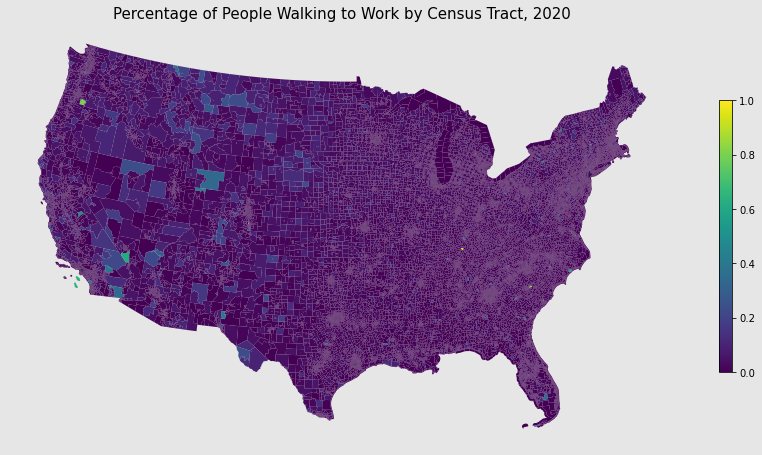

In [13]:
f, ax = plt.subplots(1, figsize=(15, 10))

tracts_viz.plot(
    column="P_WALKED", 
    linewidth=0,
    legend=True,
    legend_kwds={"shrink":0.5},
    ax=ax
)
ax.set_axis_off()
ax.set_title("Percentage of People Walking to Work by Census Tract, 2020", size=15)
f.set_facecolor('0.9')

# Products

In [14]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,INTPTLON,geometry,state,county,tract,TOTAL,BICYCLE,WALKED,P_BICYCLE,P_WALKED
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326,0,...,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.70043 31.385...",01,045,020801,1091.0,0.0,0.0,0.0,0.00000
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696,34641,...,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31354 32.808...",01,017,954200,1727.0,0.0,0.0,0.0,0.00000
2,01,017,953800,01017953800,9538,Census Tract 9538,G5020,S,515692207,11516898,...,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59333 33.000...",01,017,953800,1462.0,0.0,40.0,0.0,0.02736
3,01,017,954300,01017954300,9543,Census Tract 9543,G5020,S,132642536,178276,...,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37985 32.782...",01,017,954300,2635.0,0.0,0.0,0.0,0.00000
4,01,017,954700,01017954700,9547,Census Tract 9547,G5020,S,38036820,264376,...,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22894 32.745...",01,017,954700,1970.0,0.0,0.0,0.0,0.00000
